In [1]:
import argparse
import os
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

    

import torchvision
import torchvision.transforms as transforms

from models import *   # bring everything in the folder models

global best_prec
use_gpu = torch.cuda.is_available()
print('=> Building model...')
    
    
batch_size = 256

model_name = "resnet20_cifar"
model = resnet20_cifar()

        

normalize = transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])


train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


print_freq = 100 # every 100 batches, accuracy printed. Here, each batch includes "batch_size" data points
# CIFAR10 has 50,000 training data, and 10,000 validation data.

def train(trainloader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()   ## at the begining of each epoch, this should be reset
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.train()

    end = time.time()  # measure current time
    
    for i, (input, target) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)  # data loading time

        input, target = input.cuda(), target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec = accuracy(output, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end) # time spent to process one batch
        end = time.time()


        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   epoch, i, len(trainloader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))

            

def validate(val_loader, model, criterion ):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
         
            input, target = input.cuda(), target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = accuracy(output, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:  # This line shows how frequently print out the status. e.g., i%5 => every 5 batch, prints out
                print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1))

    print(' * Prec {top1.avg:.3f}% '.format(top1=top1))
    return top1.avg


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True) # topk(k, dim=None, largest=True, sorted=True)
                                               # will output (max value, its index)
    pred = pred.t()           # transpose
    correct = pred.eq(target.view(1, -1).expand_as(pred))   # "-1": calculate automatically

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)  # view(-1): make a flattened 1D tensor
        res.append(correct_k.mul_(100.0 / batch_size))   # correct: size of [maxk, batch_size]
    return res


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n    ## n is impact factor
        self.count += n
        self.avg = self.sum / self.count

        
def save_checkpoint(state, is_best, fdir):
    filepath = os.path.join(fdir, 'checkpoint.pth')
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(fdir, 'model_best.pth.tar'))

# Updated learning rate adjustment with warm-up and cosine annealing
def adjust_learning_rate(optimizer, epoch):
    if epoch < 5:  # Warm-up for the first 5 epochs
        lr = 0.001 + (0.1 - 0.001) * epoch / 5
    else:  # Cosine Annealing after warm-up
        lr_min = 0.001
        lr_max = 0.1
        lr = lr_min + (lr_max - lr_min) * (1 + math.cos(math.pi * (epoch - 5) / (220 - 5))) / 2  # Adjust for 220 epochs
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#model = nn.DataParallel(model).cuda()
#all_params = checkpoint['state_dict']
#model.load_state_dict(all_params, strict=False)
#criterion = nn.CrossEntropyLoss().cuda()
#validate(testloader, model, criterion)

=> Building model...
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


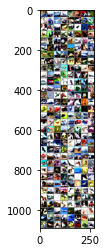

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter) ## If you run this line, the next data batch is called subsequently.

# show images
imshow(torchvision.utils.make_grid(images))


In [3]:
# # Model and optimizer setup

# criterion = nn.CrossEntropyLoss().cuda()

# # Use SGD with warm-up and cosine annealing
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# # Updated hyperparameters
# epochs = 220


# model = model.cuda()
# best_prec = 0

# if not os.path.exists('result'):
#     os.makedirs('result')

# fdir = 'result/' + str(model_name)

# if not os.path.exists(fdir):
#     os.makedirs(fdir)

# for epoch in range(0, epochs):
#     # Adjust learning rate at the start of each epoch
#     adjust_learning_rate(optimizer, epoch)

#     # Training step
#     train(trainloader, model, criterion, optimizer, epoch)

#     # Evaluate on test set
#     print("Validation starts")
#     prec = validate(testloader, model, criterion)

#     # Remember best precision and save checkpoint
#     is_best = prec > best_prec
#     best_prec = max(prec, best_prec)
#     print('Best accuracy: {:.3f}'.format(best_prec))
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'state_dict': model.state_dict(),
#         'best_prec': best_prec,
#         'optimizer': optimizer.state_dict(),
#     }, is_best, fdir)

In [4]:

fdir = 'result/'+str(model_name)+'/model_best.pth.tar'

checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])


criterion = nn.CrossEntropyLoss().cuda()

model.eval()
model.cuda()


prec = validate(testloader, model, criterion)


Test: [0/40]	Time 0.571 (0.571)	Loss 0.2720 (0.2720)	Prec 92.969% (92.969%)
 * Prec 91.280% 


In [5]:
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
best_prec = checkpoint['best_prec']

In [7]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
    def __call__(self, module, module_in):
        self.outputs.append(module_in)
    def clear(self):
        self.outputs = []  
        
######### Save inputs from selected layer ##########
save_output = SaveOutput()

for layer in model.modules():
    if isinstance(layer, torch.nn.Conv2d):
#         print("prehooked")
        layer.register_forward_pre_hook(save_output)       ## Input for the module will be grapped       
####################################################

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.cuda()
out = model(images)
print("1st convolution's input size:", save_output.outputs[1][0].size())
print("2nd convolution's input size:", save_output.outputs[3][0].size())

1st convolution's input size: torch.Size([256, 16, 32, 32])
2nd convolution's input size: torch.Size([256, 16, 32, 32])


In [8]:
# for i in range(0,20):
#     print(i,": ",save_output.outputs[i][0].size())

In [9]:
x = model.layer1[0].conv1(save_output.outputs[1][0])
x = model.layer1[0].bn1(x)
x = model.layer1[0].relu(x)

x = model.layer1[0].conv2(x)
x = model.layer1[0].bn2(x)

x = x + save_output.outputs[1][0]
x = model.layer1[0].relu(x)

In [10]:
my_output = x.cuda()
(my_output - save_output.outputs[3][0]).abs().sum()

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [11]:
# for layer in model.modules():
#     print(layer)

In [12]:
# HW

#  1. train resnet20 and vgg16 to achieve >90% accuracy 
#  2. save your trained model in the result folder 
#  3. Restart your jupyter notebook by "Kernel - Restart & Clear Output"
#  4. Load your saved model for vgg16 and validate to see the accuracy
#  5. such as the last part of "[W2S2_example2]_CNN_for_MNIST.ipynb", prehook the input layers of all the conv layers.
#  6. from the first prehooked input, compute to get the second prehooked input. 
#  7. Compare your computed second input vs. the prehooked second input.
